# One-Class Sampling - Example Notebook

In [1]:
using Pkg
Pkg.activate("..")
using SVDD
using OneClassActiveLearning
using OneClassSampling
using MLKernels
using Random
using JuMP, Gurobi
using Printf
using Plots
pyplot()

Activating environment at `/var/ssd/p/ocs-evaluation/Project.toml`


Plots.PyPlotBackend()

Silent logging

In [2]:
using Memento
Memento.config!(OneClassSampling.LOGGER, "warn"; fmt="[{level} | {name}]: {msg}")
Memento.config!(SVDD.LOGGER, "warn"; fmt="[{level} | {name}]: {msg}")

OUR_METHOD_NAME = "RAPID";

Load helpers

In [3]:
include("../scripts/util/evaluate.jl")
function evaluate_with_svdd(model::DataType, init_strategy, solver,
                            data::Array{Float64, 2}, labels::Vector{Symbol},
                            test_data::Array{Float64, 2}, test_labels::Vector{Symbol},
                            quality_metrics)
    time_train = @elapsed model = train_svdd_model(model, init_strategy, solver, data, labels)
    time_pred = @elapsed pred = predict_svdd_model(model, test_data)
    scores = evaluate_prediction(quality_metrics, test_labels, pred)
    gamma = MLKernels.getvalue(model.kernel_fct.alpha)
    C = model.C
    num_support_vectors = length(SVDD.get_support_vectors(model))
    add_evaluation_stats!(scores, time_train, time_pred, gamma, C, num_support_vectors)
    return scores, model
end

evaluate_with_svdd (generic function with 1 method)

In [4]:
function ocs_visualize_2d(x, l, x_plot_axis, sample_mask, original_model, name=nothing, c=:red)
    grid = hcat([[x,y] for x in x_plot_axis for y in x_plot_axis]...)
    grid_pred = SVDD.predict(original_model, grid)
    f = contour(x_plot_axis, x_plot_axis, reshape(grid_pred , length(x_plot_axis), length(x_plot_axis)), levels=[0], linewidth=2, color=:grey, cbar=false, legend=false)
    if !all(sample_mask)
        scatter!(x[1, .!sample_mask], x[2, .!sample_mask], ms=5, color=:grey, markerstrokecolor=:grey)
    end

    if count(sample_mask) > 1
        scores, model = evaluate_with_svdd(VanillaSVDD, init_strat, solver, x[:, sample_mask], l, x, l, quality_metrics)        
        grid = hcat([[x,y] for x in x_plot_axis for y in x_plot_axis]...)
        grid_pred = SVDD.predict(model, grid)
        contour!(x_plot_axis, x_plot_axis, reshape(grid_pred , length(x_plot_axis), length(x_plot_axis)), levels=[0], linewidth=2, color=c, style=:dash, cbar=false, legend=false)
    end
    scatter!(x[1, sample_mask], x[2, sample_mask], marker=:diamond, ms=7, color=c)
    xlims!(-7, 9.5)
    ylims!(-10, 10.5)
    annotate!([(1.25, -9, Plots.text(name, :center, 16))])
    return scores, plot(f, xaxis=false, yaxis=false, grid=false, legend=false, size=(600, 250))
end

ocs_visualize_2d (generic function with 3 methods)

In [5]:
function run_visualize_2d(s, x, l, x_plot_axis, title_ext, c=:red)
    sampling_failed = false
    sample_mask = falses(length(l))
    try
        Random.seed!(0)
        sample_mask = OneClassSampling.sample(s, x, l)
    catch e
        @show e
        sampling_failed = true
    end
    title_plot = @sprintf "%s (|S| = %d)" title_ext count(sample_mask)
    scores, p = ocs_visualize_2d(x, l, x_plot_axis, sample_mask, original_model, title_plot, c)
    pad = length(title_ext) > 5 ? "\t" : "\t\t"
    if sampling_failed
        stats = @sprintf "[%s]%s Sampling failed" title_ext pad
    else
        stats = @sprintf "[%s]%s Sample size %5d\tratio = %3.2f" title_ext pad count(sample_mask) (count(sample_mask) / length(l))
        if scores !== nothing
            stats *= @sprintf "\t#SVs = %5d" scores[:num_support_vectors]
        end
    end
    println(stats)
    return p
end

run_visualize_2d (generic function with 2 methods)

### Model Parameters

In [6]:
gurobi_env = Gurobi.Env()
solver = with_optimizer(Gurobi.Optimizer, gurobi_env; OutputFlag=0, Threads=1)
quality_metrics = Dict(:mcc => matthews_corr, :kappa => cohens_kappa, :f1 => f1_score)

Academic license - for non-commercial use only


Dict{Symbol,Function} with 3 entries:
  :mcc   => matthews_corr
  :f1    => f1_score
  :kappa => cohens_kappa

### Sampling Strategies

In [7]:
function ss(threshold_strat, gamma)
    return [
        RAPID(threshold_strat, gamma),
        BPS(nothing, 0.01),
        DAEDS(30, 0.1, 0.3),
        DBSRSVDD(7, 0.3),
        HSR(20, 0.01),
        IESRSVDD(gamma, 0.5),
        FBPE(360),
        KFNCBD(100, 0.2),
        NDPSR(20, 7)
    ]
end

ss (generic function with 1 method)

Generate Data

In [8]:
Random.seed!(0)

r, noise, n = 5, 0.1, 400
x = hcat(randn(2, Int(n / 2)) * 2 .+ 3, randn(2, Int(n / 2)) * 1.5 .- 2)
l = fill(:inlier, n)

x_plot = hcat([[x, y] for x in range(-10, stop=12, length=100) for y in range(-10, stop=12, length=100)]...)
x_plot_axis = collect(range(-10, stop=12, length=100))

gamma = 0.025
init_strat = SVDD.SimpleCombinedStrategy(SVDD.FixedGammaStrategy(MLKernels.GaussianKernel(gamma)), SVDD.FixedCStrategy(1))

SimpleCombinedStrategy(FixedGammaStrategy(SquaredExponentialKernel(0.025)), FixedCStrategy(1))

In [9]:
_, original_model = evaluate_with_svdd(VanillaSVDD, init_strat, solver, x, l, x, l, quality_metrics);

[RAPID]		 Sample size    31	ratio = 0.08	#SVs =     8
[BPS]		 Sample size     8	ratio = 0.02	#SVs =     8
[DAEDS]		 Sample size    77	ratio = 0.19	#SVs =     8
[DBSRSVDD]	 Sample size     9	ratio = 0.02	#SVs =     5
[HSR]		 Sample size   398	ratio = 0.99	#SVs =     9
[IESRSVDD]	 Sample size   195	ratio = 0.49	#SVs =     8
[FBPE]		 Sample size    36	ratio = 0.09	#SVs =     8
[KFNCBD]	 Sample size    80	ratio = 0.20	#SVs =     8
[NDPSR]		 Sample size    95	ratio = 0.24	#SVs =     8


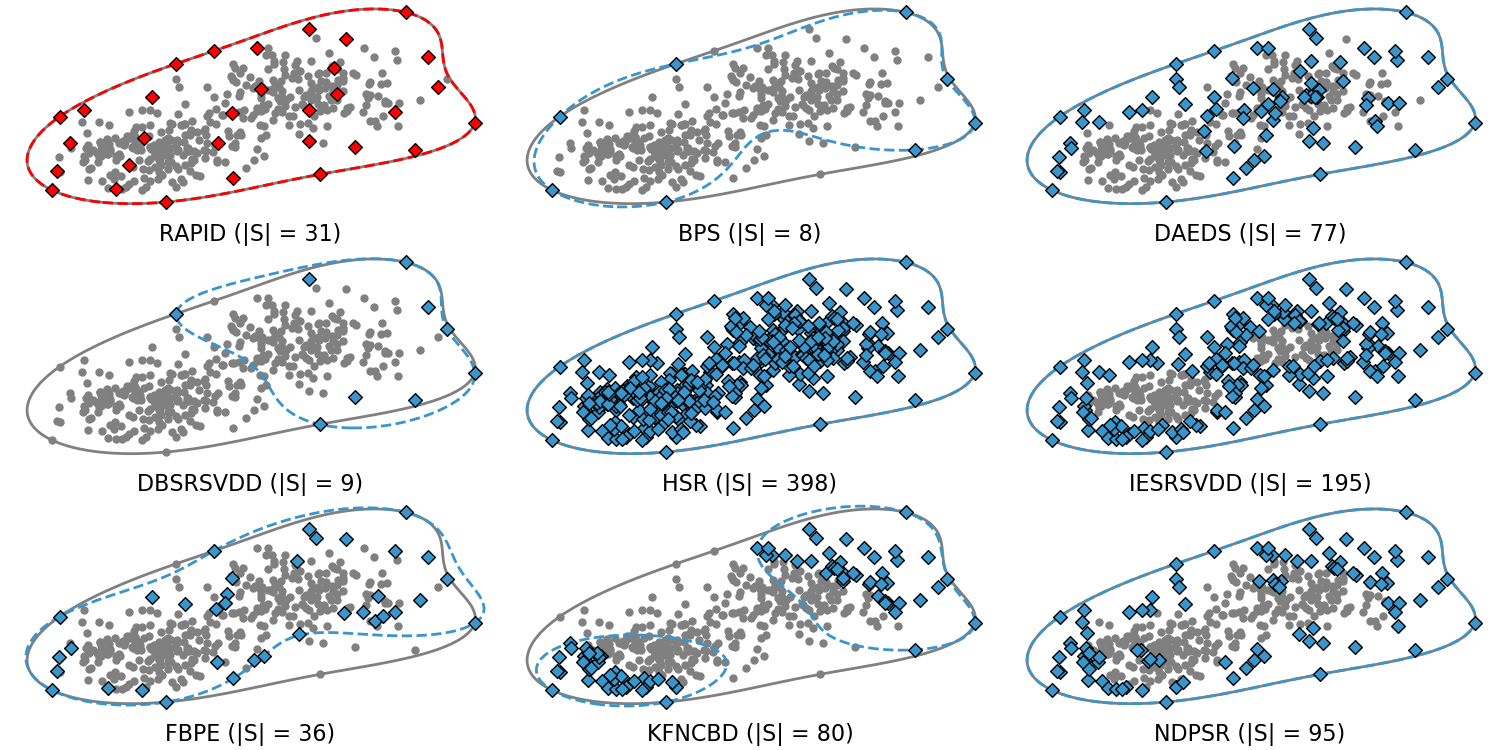

In [10]:
sampling_gamma = 0.3
threshold_strat = GroundTruthThresholdStrategy()

ps = map(s -> run_visualize_2d(s, x, l, x_plot_axis, string(typeof(s)), occursin(OUR_METHOD_NAME, string(s)) ? :red : RGB(57/256, 150 / 256, 204 / 256)),
         ss(threshold_strat, sampling_gamma))
p = plot(ps..., layout = (3, 3), size=(1500, 250*3), legend=false, topmargin=50)

In [11]:
savefig(p, "../plots/example_all_methods.pdf")
savefig(p, "../plots/example_all_methods.png")

Compact version (2x4) without HSR:

In [12]:
function ss(threshold_strat, gamma)
    return [
        RAPID(threshold_strat, gamma),
        BPS(nothing, 0.01),
        DAEDS(30, 0.1, 0.3),
        DBSRSVDD(7, 0.3),
        IESRSVDD(gamma, 0.5),
        FBPE(360),
        KFNCBD(100, 0.2),
        NDPSR(20, 7),
    ]
end

ss (generic function with 1 method)

[RAPID]		 Sample size    31	ratio = 0.08	#SVs =     8
[BPS]		 Sample size     8	ratio = 0.02	#SVs =     8
[DAEDS]		 Sample size    77	ratio = 0.19	#SVs =     8
[DBSRSVDD]	 Sample size     9	ratio = 0.02	#SVs =     5
[IESRSVDD]	 Sample size   195	ratio = 0.49	#SVs =     8
[FBPE]		 Sample size    36	ratio = 0.09	#SVs =     8
[KFNCBD]	 Sample size    80	ratio = 0.20	#SVs =     8
[NDPSR]		 Sample size    95	ratio = 0.24	#SVs =     8


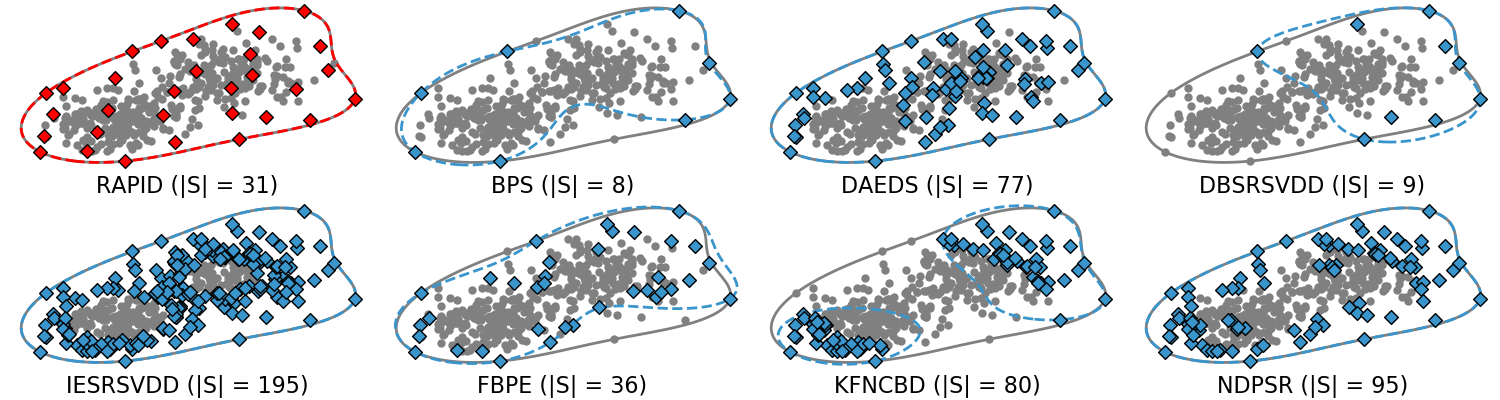

In [13]:
ps = map(s -> run_visualize_2d(s, x, l, x_plot_axis, string(typeof(s)), occursin(OUR_METHOD_NAME, string(s)) ? :red : RGB(57/256, 150 / 256, 204 / 256)),
         ss(threshold_strat, sampling_gamma))
p = plot(ps..., layout = (2, 4), size=(1500, 400), legend=false, topmargin=50)

In [14]:
savefig(p, "../plots/example_compact.pdf")
savefig(p, "../plots/example_compact.png")